In [1]:
#rm(list=ls())

#Se utiliza pacman para instalar y cargar paquetes
if(!require('pacman')) install.packages('pacman')
pacman::p_load(tidyverse,
               webshot2,
               showtext,
               magick,
               gt,
               scales)



Cargando paquete requerido: pacman



In [2]:
font_add_google("Roboto", "rob")
showtext_auto()

paleta_ipdp <- c("#9F2241",
                 "#BC955C",
                 "#AC6D14",
                 "#799B48",
                 "#E02B75",
                 "#F08217",
                 "#f5aeb8",
                 "#de7aaf",
                 "black",
                 "#e5074c",
                 "#73cae6",
                 "#266cb4",
                 "#027A35")

In [3]:
#Función para crear tabla
###Si existe algún problema al momento del output de la función crea_tabla, correr remotes::install_github("rstudio/chromote")

crea_tabla <- function(df, titulo, subtitulo,nota="",nombre_archivo){

  # Format the numeric columns with commas
  formatted_df <- df #|>
    #mutate(across(where(is.numeric), ~scales::comma(.)))

  # Checa si existe la columna "Organismo" para agrupar la tabla
  if("Organismo" %in% names(df)) {
    gt_table <- formatted_df |>
      gt(rowname_col = "Organismo",
         groupname_col = "Año",
         row_group_as_column = TRUE)
  } else {
    gt_table <- formatted_df |>
      gt()
  }

  gt_table <- gt_table |>
    tab_options(
      column_labels.font.weight = "bold",
    ) |>
    tab_header(
      title = md(paste0("**", titulo, "**")),
      subtitle=md(paste0("*", subtitulo, "*"))
    ) |>
    tab_options(
      table.font.names = 'Roboto',
      source_notes.font.size = 8,
      table.border.top.width = px(0),
      table.border.bottom.width = px(0),
      column_labels.background.color = "#9F2241",
      column_labels.font.size = 10,
    heading.title.font.size = 15,
    ) |>
    cols_align(
      align = "center"
    ) |>
    tab_source_note(
      source_note = md("")
    ) |>
    tab_source_note(
      source_note = md(nota)
    ) |>
    tab_source_note(
      source_note = md("")
    )|>
    cols_width(
      everything() ~ px(180)
    )

  # Salva la tabla
  gtsave(gt_table, filename = nombre_archivo)

  # Muestra la imagen
  img <- image_read(nombre_archivo)
  return(img)
}

In [5]:
ingresos_cdmx <- read_csv("https://datos.cdmx.gob.mx/dataset/f04b7092-782d-4206-9590-ac8b577891dc/resource/77c2e268-f5b4-4cdf-a705-13a73a9608b3/download/ingresos_2024_01.csv", 
                          col_types = NULL)

Rows: 2281 Columns: 16
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (10): periodo, desc_tipo_recurso_clase, desc_rubro, desc_tipo, clase, de...
dbl  (6): ciclo, tipo_recurso_clase, rubro, tipo, monto_estimado, monto_reca...

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [6]:
#MONTO TOTAL DE INGRESOS RECAUDADOS
recaudados_por_ciclo <- ingresos_cdmx|>
  filter(periodo == "Anual")|>
  group_by(ciclo)|>
  summarise(montoest = sum(monto_estimado, na.rm = TRUE)/1000000)|>
  mutate(var = round((montoest/lag(montoest, 1)-1)*100,1), 
         var = as.character(var),
         var = case_when(is.na(var) ~ "-",
          TRUE ~ var))|>
  rename(`Monto estimado`=montoest,
         `Año` = ciclo, 
         `Var. porcentual`= var)|>
  mutate(`Monto estimado` = format(`Monto estimado`, big.mark = ",", decimal.mark = "."))

   

recaudados_por_ciclo


Año,Monto estimado,Var. porcentual
<dbl>,<chr>,<chr>
2018,"226,851.9",-
2019,"234,016.3",3.2
2020,"238,975.8",2.1
2021,"217,962.2",-8.8
2022,"234,000.9",7.4
2023,"248,415.1",6.2
2024,"267,965.4",7.9


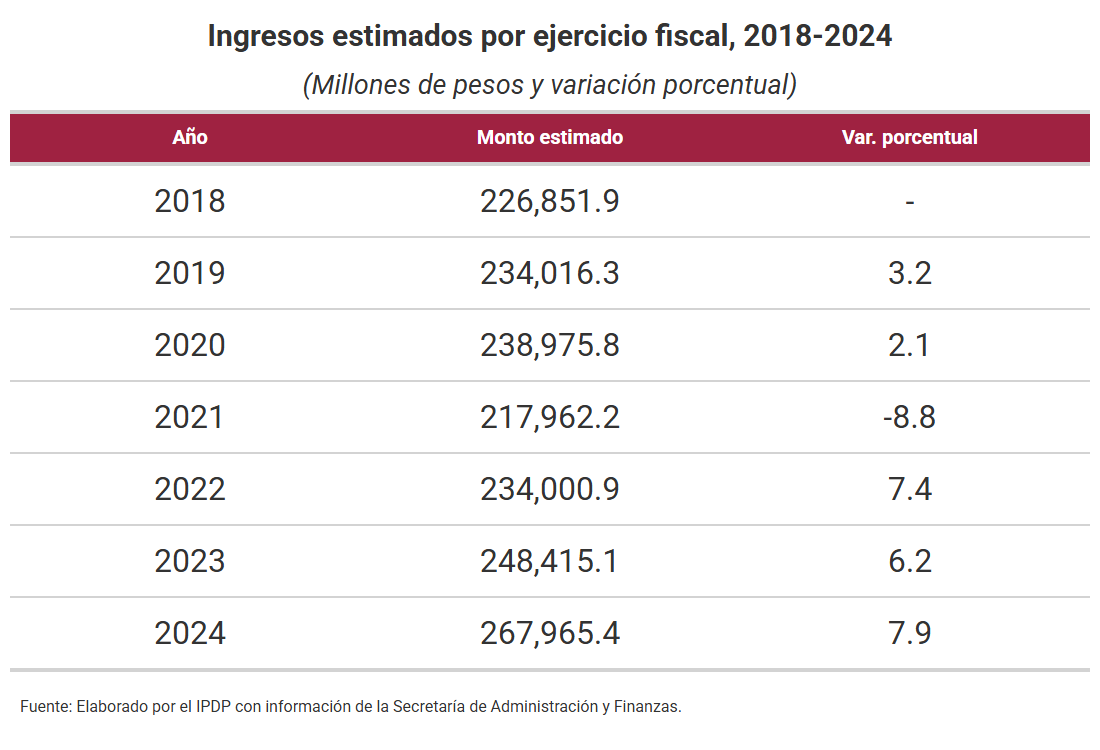

# A tibble: 1 × 7
  format width height colorspace matte filesize density
  <chr>  <int>  <int> <chr>      <lgl>    <int> <chr>  
1 PNG     1100    750 sRGB       FALSE    53054 72x72  

In [6]:
crea_tabla(recaudados_por_ciclo,"Ingresos estimados por ejercicio fiscal, 2018-2024","(Millones de pesos y variación porcentual)","Fuente: Elaborado por el IPDP con información de la Secretaría de Administración y Finanzas.","tabla_ingresos.png")

In [7]:
#MONTO TOTAL DE INGRESO RECAUDADO POR TIPO DE INGRESO
recaudados_por_ciclo_por_clase <- ingresos_cdmx |>
  filter(periodo == "Anual") |>
  group_by(ciclo, desc_tipo_recurso_clase) |>
  summarise(montoest = sum(monto_estimado, na.rm = TRUE) / 1000000) |>
  mutate(pct = round(((montoest * 100) / sum(montoest)), 1))|>
  rename(
         clase = desc_tipo_recurso_clase) |>
  mutate(clase = case_when(
    clase == "Ingresos del Sector Paraestatal" ~ "Sector Paraestatal",
    clase == "Ingresos locales" ~ "Locales",
    TRUE ~ clase
  )) |>
  ungroup() |>
  group_by(ciclo) |>
  #Ordenar los factores
  mutate(clase = fct_reorder(clase, pct, .desc = TRUE)) |>
  ungroup()

recaudados_por_ciclo_por_clase

`summarise()` has grouped output by 'ciclo'. You can override using the
`.groups` argument.


ciclo,clase,montoest,pct
<dbl>,<fct>,<dbl>,<dbl>
2018,Endeudamiento,5500.00,2.4
2018,Sector Paraestatal,15981.90,7.0
2018,Locales,91886.01,40.5
2018,Recursos federales,113483.99,50.0
2019,Endeudamiento,5500.00,2.4
2019,Sector Paraestatal,16344.70,7.0
2019,Locales,92762.95,39.6
2019,Recursos federales,119408.68,51.0
2020,Endeudamiento,4000.00,1.7


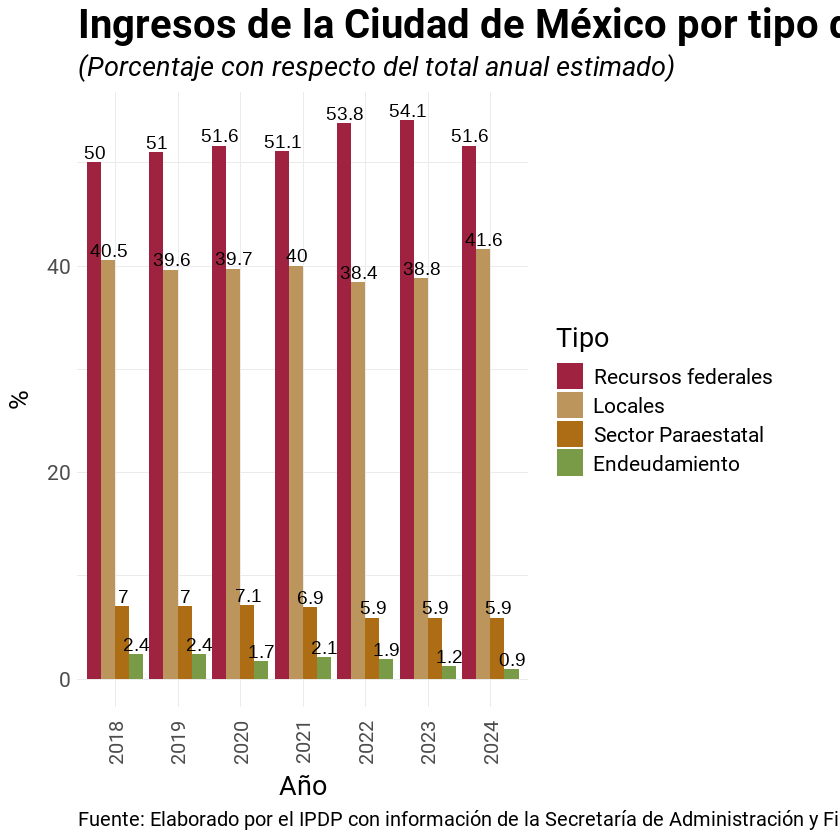

In [8]:
# Gráfica
recaudados_por_ciclo_por_clase|>
ggplot(aes(x = factor(ciclo), y = pct, fill = clase)) +
  geom_col(position = "dodge") +
  geom_text(aes(label = round(pct, 1)), position = position_dodge(width = 0.9), vjust = -0.3, size = 5, color = "black")+
  scale_fill_manual("Tipo",values = paleta_ipdp) +
  labs(
    title = "Ingresos de la Ciudad de México por tipo de recurso, 2018-2024",
    subtitle = "(Porcentaje con respecto del total anual estimado)",
    x = "Año",
    y = "%",
    fill = "Tipo", 
    caption = "Fuente: Elaborado por el IPDP con información de la Secretaría de Administración y Finanzas"
  ) +
  theme_minimal() +
    theme(#axis.text.x = element_text(angle = 45, hjust = 1),
            plot.title = element_text(hjust = 0, size=30,face="bold"),
        legend.position = "right",
            plot.subtitle = element_text(hjust = 0, size=20, face="italic"),
            plot.caption = element_text(hjust = 0,size=15),
            axis.text.x = element_text(angle = 90, vjust = 0.5,size=15),
            text=element_text("rob",size=20))

ggsave("ingresos_por_tipo.png",width=15,height=8, dpi = 100, bg="white")

In [9]:
#PORCENTAJE DE PARTICIPACIÓN DE LOS INGRESOS LOCALES CON RESPECTO AL TOTAL DE LOS INGRESOS ANUALES
ing_loc <- ingresos_cdmx |>
  filter(periodo == "Anual") |>
  group_by(ciclo, desc_tipo_recurso_clase, desc_clase) |>
  summarise(montoest = sum(monto_estimado, na.rm = TRUE)/1000000)|> #Millones de pesos
  ungroup() |>
  group_by(ciclo) |>
  mutate(porcentaje = round((montoest * 100) / sum(montoest), 1)) |>
  ungroup() |>
  filter(desc_tipo_recurso_clase == "Ingresos locales")|>
  rename(`Monto estimado` = montoest,
         Porcentaje = porcentaje, 
         `Clase del recurso` = desc_tipo_recurso_clase, 
         Clase = desc_clase, 
         Año = ciclo)

#VALIDACIÓN
sumas <- ing_loc|>
filter(Año == 2019)

sum(sumas$`Monto estimado`)
sum(sumas$Porcentaje)

`summarise()` has grouped output by 'ciclo', 'desc_tipo_recurso_clase'. You can
override using the `.groups` argument.


[1] 92762.95

[1] 39.3

In [10]:
#PRINCIPALES INGRESOS LOCALES, QUE TIENEN LA  MAYOR PARTICIPACIÓN EN LOS INGRESOS CON RESPECTO AL TOTAL DE LOS INGRESOS ANUALES
representativos_ciclo <- ing_loc|>
filter(Clase %in% c("Predial", 
                        "Productos derivados del uso y aprovechamiento de bienes no sujetos a régimen de dominio público", 
                        "Sobre Nóminas", 
                        "Sobre Adquisición de Inmuebles", 
                        "Por la Prestación de Servicios por el Suministro de Agua",
                        "Control Vehicular"))

representativos_ciclo                        

#PORCENTAJE TOTAL QUE REPRESENTAN LOS INGRESOS LOCALES ANTERIORMENTE MENCIONADOS CON RESPECTO AL TOTAL DE LOS INGRESOS
agrupados_ciclo <- representativos_ciclo|>
group_by(Año)|>
summarise(sumas = sum(Porcentaje))

agrupados_ciclo

Año,Clase del recurso,Clase,Monto estimado,Porcentaje
<dbl>,<chr>,<chr>,<dbl>,<dbl>
2018,Ingresos locales,Por la Prestación de Servicios por el Suministro de Agua,6869.260,3.0
2018,Ingresos locales,Predial,15397.465,6.8
2018,Ingresos locales,Productos derivados del uso y aprovechamiento de bienes no sujetos a régimen de dominio público,10916.779,4.8
2018,Ingresos locales,Sobre Adquisición de Inmuebles,9310.551,4.1
2018,Ingresos locales,Sobre Nóminas,25664.936,11.3
2019,Ingresos locales,Por la Prestación de Servicios por el Suministro de Agua,7230.896,3.1
2019,Ingresos locales,Predial,16973.461,7.3
2019,Ingresos locales,Productos derivados del uso y aprovechamiento de bienes no sujetos a régimen de dominio público,12048.247,5.1
2019,Ingresos locales,Sobre Adquisición de Inmuebles,8486.443,3.6


Año,sumas
<dbl>,<dbl>
2018,30.0
2019,29.5
2020,30.7
2021,31.6
2022,31.2
2023,31.3
2024,33.2


In [11]:
#MONTO TOTAL DE INGRESO RECAUDADO POR RUBRO
recaudados_por_ciclo_por_rubro <- ingresos_cdmx|>
  filter(periodo == "Anual")|>
  group_by(ciclo, desc_rubro)|>
  summarise(montoest = sum(monto_estimado, na.rm = TRUE)/1000000) #MILLONES DE PESOS

recaudados_por_ciclo_por_rubro

`summarise()` has grouped output by 'ciclo'. You can override using the
`.groups` argument.


ciclo,desc_rubro,montoest
<dbl>,<chr>,<dbl>
2018,Aprovechamientos,6649.702
2018,Cuotas y Aportaciones de Seguridad Social,3596.722
2018,Derechos,14003.619
2018,Impuestos,57940.607
2018,Ingresos Derivados de Financiamientos,5500.000
2018,"Ingresos por Venta de Bienes, Prestación de Servicios y Otros Ingresos",12385.174
2018,"Participaciones, Aportaciones, Convenios, Incentivos Derivados de la Colaboración Fiscal y Fondos Distintos de Aportaciones",113483.988
2018,Productos,13292.085
2019,Aprovechamientos,6178.237


In [18]:
#TCMA DE LOS INGRESOS LOCALES DESAGREGADO POR CLASE DEL INGRESO
tasas_rubros <- ingresos_cdmx |>
  filter(ciclo %in% c(2018, 2024), 
         desc_tipo_recurso_clase == "Ingresos locales")|>
  select(ciclo, desc_clase, monto_estimado) |>
  group_by(ciclo, desc_clase) |>
  summarise(montoest = sum(monto_estimado, na.rm = TRUE)/1000000) |>
  pivot_wider(names_from = ciclo, values_from = montoest, names_prefix = "ciclo_") |>
  mutate(tcma = round(((ciclo_2024 / ciclo_2018)^(1/(2024-2018)) - 1) * 100,1)) |>
  arrange(desc(tcma))



tasas_rubros


`summarise()` has grouped output by 'ciclo'. You can override using the
`.groups` argument.


desc_clase,ciclo_2018,ciclo_2024,tcma
<chr>,<dbl>,<dbl>,<dbl>
"Por la Supervisión y Revisión de las Obras Públicas Sujetas a Contrato, así como la Auditoría de las mismas",86.062546,432.624945,30.9
Predial,15397.464713,40598.070374,17.5
Por los Servicios de Alineamiento y Señalamiento de Número Oficial y Expedición de Constancias de Zonificación y Uso de Inmuebles,78.538296,188.822093,15.7
Por el Uso o Aprovechamiento de Inmuebles,55.738394,113.655861,12.6
Por la Prestación de Servicios de Hospedaje,566.080271,1061.389315,11.0
Por la Prestación de Servicios de Registro Civil,240.906580,441.780449,10.6
Sobre Nóminas,25664.936280,45141.263113,9.9
Por los Servicios de Control Vehicular,2470.880193,4283.761706,9.6
Aprovechamientos provenientes de obras públicas,384.105729,653.501086,9.3
